In [17]:
from torchsummary import summary
from torch import nn
import torch
from collections import OrderedDict
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F

### 4.1 定义模型类

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 压平输入数据
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()

In [18]:
summary(model,input_size=(1, 28, 28),batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                  [64, 512]         401,920
              ReLU-3                  [64, 512]               0
            Linear-4                  [64, 512]         262,656
              ReLU-5                  [64, 512]               0
            Linear-6                   [64, 10]           5,130
              ReLU-7                   [64, 10]               0
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.39
Params size (MB): 2.55
Estimated Total Size (MB): 4.14
----------------------------------------------------------------


### 4.2 定义模型容器

#### Sequential

In [42]:
X = torch.randn((1,784))

In [47]:
torch.manual_seed(42)
model1 = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

In [49]:
torch.manual_seed(42)
layer2=OrderedDict([
    ('linear1',nn.Linear(28*28, 512)),
    ('relu1',nn.ReLU()),
    ('linear2',nn.Linear(512, 512)),
    ('relu2',nn.ReLU()),
    ('linear3',nn.Linear(512, 10)),
    ('relu3',nn.ReLU())
])
model2 = nn.Sequential(layer2)

In [52]:
torch.manual_seed(42)
model3=nn.Sequential()
model3.add_module('linear1',nn.Linear(28*28, 512))
model3.add_module('relu1',nn.ReLU())
model3.add_module('linear2',nn.Linear(512, 512))
model3.add_module('relu2',nn.ReLU())
model3.add_module('linear3',nn.Linear(512, 10))
model3.add_module('relu3',nn.ReLU())

In [54]:
model1(X), model2(X), model3(X)

(tensor([[0.0000, 0.0066, 0.0020, 0.0000, 0.0000, 0.0000, 0.0131, 0.0932, 0.0000,
          0.0439]], grad_fn=<ReluBackward0>),
 tensor([[0.0000, 0.0066, 0.0020, 0.0000, 0.0000, 0.0000, 0.0131, 0.0932, 0.0000,
          0.0439]], grad_fn=<ReluBackward0>),
 tensor([[0.0000, 0.0066, 0.0020, 0.0000, 0.0000, 0.0000, 0.0131, 0.0932, 0.0000,
          0.0439]], grad_fn=<ReluBackward0>))

#### ModuleDict

In [63]:
class MyModuleDict(nn.Module):
    def __init__(self):
        super(MyModuleDict, self).__init__()
        self.choices = nn.ModuleDict({
                'conv': nn.Conv2d(10, 10, 3),
                'pool': nn.MaxPool2d(3)
        })
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU()],
                ['prelu', nn.PReLU()]
        ])

    def forward(self, x, choice, act):
        x = self.choices[choice](x)
        x = self.activations[act](x)
        return x

In [64]:
X=  torch.randn((1, 10, 32, 32))
model_dict4= MyModuleDict()
output = model_dict4.forward(X,'conv','lrelu')

#### ModuleList

In [67]:
class MyModuleList(nn.Module):
    def __init__(self):
        super(MyModuleList, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(10)])

    def forward(self, x):
        for i, linear in enumerate(self.linears):
            x = linear(x)
        return x

In [68]:
X = torch.randn((1, 10))
model5=MyModuleList()
output=model5(X)

#### 不用容器的写法

In [84]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1=nn.Linear(28*28, 512)
        self.linear2=nn.Linear(512, 512)
        self.linear3=nn.Linear(512, 10)
        self.relu1=nn.ReLU()
        self.relu2=nn.ReLU()
        self.relu3=nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        return x
    
model = NeuralNetwork()

In [85]:
summary(model,input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
              ReLU-7                   [-1, 10]               0
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


### 4.4 正则化

#### dropout

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [41]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
)

In [108]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(test_data, batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [154]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,p):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.Dropout(p),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cpu device


In [155]:
# without dropout
model_wodrop = NeuralNetwork(0).to(device)
print(model_wodrop)
loss_fn = nn.CrossEntropyLoss()
optimizer_wodrop = torch.optim.SGD(model_wodrop.parameters(), lr=1e-3)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
    (7): ReLU()
  )
)


In [156]:
# with dropout
model_drop = NeuralNetwork(0.5).to(device)
print(model_drop)
loss_fn = nn.CrossEntropyLoss()
optimizer_drop = torch.optim.SGD(model_drop.parameters(), lr=1e-3)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
    (7): ReLU()
  )
)


In [157]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss=0
    correct=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss = train_loss/len(dataloader)
    correct /= size
    return correct

In [158]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss= 0
    correct=0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = test_loss/len(dataloader)
    correct /= size
    return correct

In [159]:
epochs = 40
epoch_array=  np.arange(1,epochs+1,dtype=np.float64)
train_loss_wodrop = np.zeros_like(epoch_array)
test_loss_wodrop = np.zeros_like(epoch_array)
for i in range(epochs):
    print(f'epoch {i+1} begin:')
    epoch_loss =  train(train_dataloader, model_wodrop, loss_fn, optimizer_wodrop)
    train_loss_wodrop[i] =  epoch_loss
    epoch_loss =  test(test_dataloader, model_wodrop, loss_fn)
    test_loss_wodrop[i] =  epoch_loss

epoch 1 begin:
epoch 2 begin:
epoch 3 begin:
epoch 4 begin:
epoch 5 begin:
epoch 6 begin:
epoch 7 begin:
epoch 8 begin:
epoch 9 begin:
epoch 10 begin:
epoch 11 begin:
epoch 12 begin:
epoch 13 begin:
epoch 14 begin:
epoch 15 begin:
epoch 16 begin:
epoch 17 begin:
epoch 18 begin:
epoch 19 begin:
epoch 20 begin:
epoch 21 begin:
epoch 22 begin:
epoch 23 begin:
epoch 24 begin:
epoch 25 begin:
epoch 26 begin:
epoch 27 begin:
epoch 28 begin:
epoch 29 begin:
epoch 30 begin:
epoch 31 begin:
epoch 32 begin:
epoch 33 begin:
epoch 34 begin:
epoch 35 begin:
epoch 36 begin:
epoch 37 begin:
epoch 38 begin:
epoch 39 begin:
epoch 40 begin:


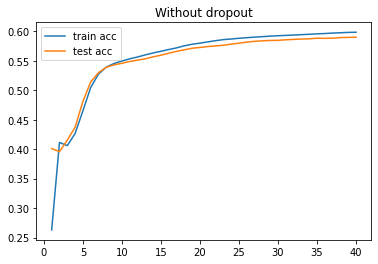

In [163]:
plt.plot(epoch_array,train_loss_wodrop,label='train acc')
plt.plot(epoch_array,test_loss_wodrop,label='test acc')
plt.title('Without dropout')
plt.legend()

In [161]:
epochs = 40
epoch_array=  np.arange(1,epochs+1,dtype=np.float64)
train_loss_drop = np.zeros_like(epoch_array)
test_loss_drop = np.zeros_like(epoch_array)
for i in range(epochs):
    print(f'epoch {i+1} begin:')
    epoch_loss =  train(train_dataloader, model_drop, loss_fn, optimizer_drop)
    train_loss_drop[i] =  epoch_loss
    epoch_loss =  test(test_dataloader, model_drop, loss_fn)
    test_loss_drop[i] =  epoch_loss

epoch 1 begin:
epoch 2 begin:
epoch 3 begin:
epoch 4 begin:
epoch 5 begin:
epoch 6 begin:
epoch 7 begin:
epoch 8 begin:
epoch 9 begin:
epoch 10 begin:
epoch 11 begin:
epoch 12 begin:
epoch 13 begin:
epoch 14 begin:
epoch 15 begin:
epoch 16 begin:
epoch 17 begin:
epoch 18 begin:
epoch 19 begin:
epoch 20 begin:
epoch 21 begin:
epoch 22 begin:
epoch 23 begin:
epoch 24 begin:
epoch 25 begin:
epoch 26 begin:
epoch 27 begin:
epoch 28 begin:
epoch 29 begin:
epoch 30 begin:
epoch 31 begin:
epoch 32 begin:
epoch 33 begin:
epoch 34 begin:
epoch 35 begin:
epoch 36 begin:
epoch 37 begin:
epoch 38 begin:
epoch 39 begin:
epoch 40 begin:


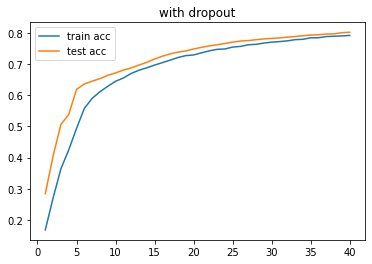

In [164]:
plt.plot(epoch_array,train_loss_drop,label='train acc')
plt.plot(epoch_array,test_loss_drop,label='test acc')
plt.title('with dropout')
plt.legend()

In [127]:
train_loss_drop

array([2.31604085, 2.29500786, 2.27759864, 2.25430542, 2.2169927 ,
       2.17303303, 2.11503803, 2.04792284, 1.95960178, 1.85815818,
       1.76037811, 1.67046976, 1.59823282, 1.5344492 , 1.47592707])

In [128]:
test_loss_drop

array([2.28788005, 2.2677436 , 2.23720774, 2.19427744, 2.13454214,
       2.06110843, 1.97086331, 1.86445748, 1.73260515, 1.59330956,
       1.47227413, 1.3712639 , 1.29249225, 1.22992534, 1.1776903 ])

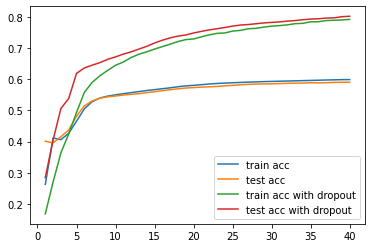

In [166]:
plt.plot(epoch_array,train_loss_wodrop,label='train acc')
plt.plot(epoch_array,test_loss_wodrop,label='test acc')
plt.plot(epoch_array,train_loss_drop,label='train acc with dropout')
plt.plot(epoch_array,test_loss_drop,label='test acc with dropout')
plt.legend()

#### L1/L2

In [178]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cpu device


In [189]:
model_l1 = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_l1 = torch.optim.SGD(model_l1.parameters(), lr=1e-3)

model_l2 = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_l2 = torch.optim.SGD(model_l2.parameters(), lr=1e-3)

In [190]:
def train(dataloader, model, loss_fn, optimizer, re):
    size = len(dataloader.dataset)
    model.train()
    train_loss=0
    correct=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # add penalty
        re_lambda = 0.001
        if re =='l2':
            re_norm = sum(p.pow(2.0).sum()  for p in model.parameters())
        elif re =='l1':
            re_norm = sum(abs(p).sum()  for p in model.parameters())
        loss = loss + re_lambda * re_norm
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss = train_loss/len(dataloader)
    correct /= size
    return correct

In [191]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss= 0
    correct=0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = test_loss/len(dataloader)
    correct /= size
    return correct

In [192]:
epochs = 20
epoch_array=  np.arange(1,epochs+1,dtype=np.float64)
train_acc_l2 = np.zeros_like(epoch_array)
test_acc_l2 = np.zeros_like(epoch_array)
train_acc_l1 = np.zeros_like(epoch_array)
test_acc_l1 = np.zeros_like(epoch_array)
for i in range(epochs):
    print(f'epoch {i+1} begin:')
    train_acc_l1[i] =  train(train_dataloader, model_l1, loss_fn, optimizer_l1,'l1')
    test_acc_l1[i] =  test(test_dataloader, model_l1, loss_fn)
    train_acc_l2[i] =  train(train_dataloader, model_l2, loss_fn, optimizer_l2,'l2')
    test_acc_l2[i] =  test(test_dataloader, model_l2, loss_fn)

epoch 1 begin:
epoch 2 begin:
epoch 3 begin:
epoch 4 begin:
epoch 5 begin:
epoch 6 begin:
epoch 7 begin:
epoch 8 begin:
epoch 9 begin:
epoch 10 begin:
epoch 11 begin:
epoch 12 begin:
epoch 13 begin:
epoch 14 begin:
epoch 15 begin:
epoch 16 begin:
epoch 17 begin:
epoch 18 begin:
epoch 19 begin:
epoch 20 begin:


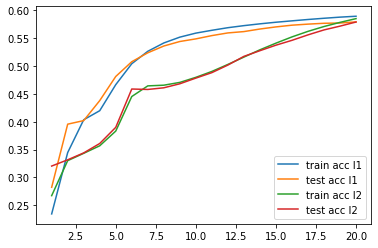

In [193]:
plt.plot(epoch_array,train_acc_l1,label='train acc l1')
plt.plot(epoch_array,test_acc_l1,label='test acc l1')
plt.plot(epoch_array,train_acc_l2,label='train acc l2')
plt.plot(epoch_array,test_acc_l2,label='test acc l2')
plt.legend()

#### BN

In [196]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cpu device


In [202]:
model_bn = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer_bn= torch.optim.SGD(model_bn.parameters(), lr=1e-3)

In [203]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss=0
    correct=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss = train_loss/len(dataloader)
    correct /= size
    return correct

In [204]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss= 0
    correct=0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = test_loss/len(dataloader)
    correct /= size
    return correct

In [205]:
epochs = 20
epoch_array=  np.arange(1,epochs+1,dtype=np.float64)
train_acc_bn = np.zeros_like(epoch_array)
test_acc_bn = np.zeros_like(epoch_array)
# train_acc_l1 = np.zeros_like(epoch_array)
# test_acc_l1 = np.zeros_like(epoch_array)
for i in range(epochs):
    print(f'epoch {i+1} begin:')
    train_acc_bn[i] =  train(train_dataloader, model_bn, loss_fn, optimizer_bn)
    test_acc_bn[i] =  test(test_dataloader, model_bn, loss_fn)

epoch 1 begin:
epoch 2 begin:
epoch 3 begin:
epoch 4 begin:
epoch 5 begin:
epoch 6 begin:
epoch 7 begin:
epoch 8 begin:
epoch 9 begin:
epoch 10 begin:
epoch 11 begin:
epoch 12 begin:
epoch 13 begin:
epoch 14 begin:
epoch 15 begin:
epoch 16 begin:
epoch 17 begin:
epoch 18 begin:
epoch 19 begin:
epoch 20 begin:


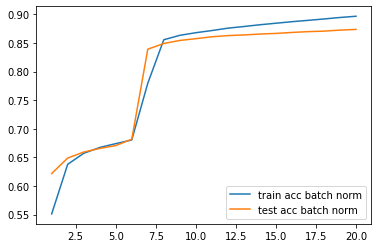

In [206]:
plt.plot(epoch_array,train_acc_bn,label='train acc batch norm')
plt.plot(epoch_array,test_acc_bn,label='test acc batch norm')
# plt.plot(epoch_array,train_acc_l2,label='train acc l2')
# plt.plot(epoch_array,test_acc_l2,label='test acc l2')
plt.legend()